# Reconocimiento estadístico de patrones
## Procesamiento de imágenes
    

In [1]:
#Cargar librerias
library(jpeg)
library(grid)
library(igraph)
library(kernlab)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



### 1 . Leer y visualizar una imagen

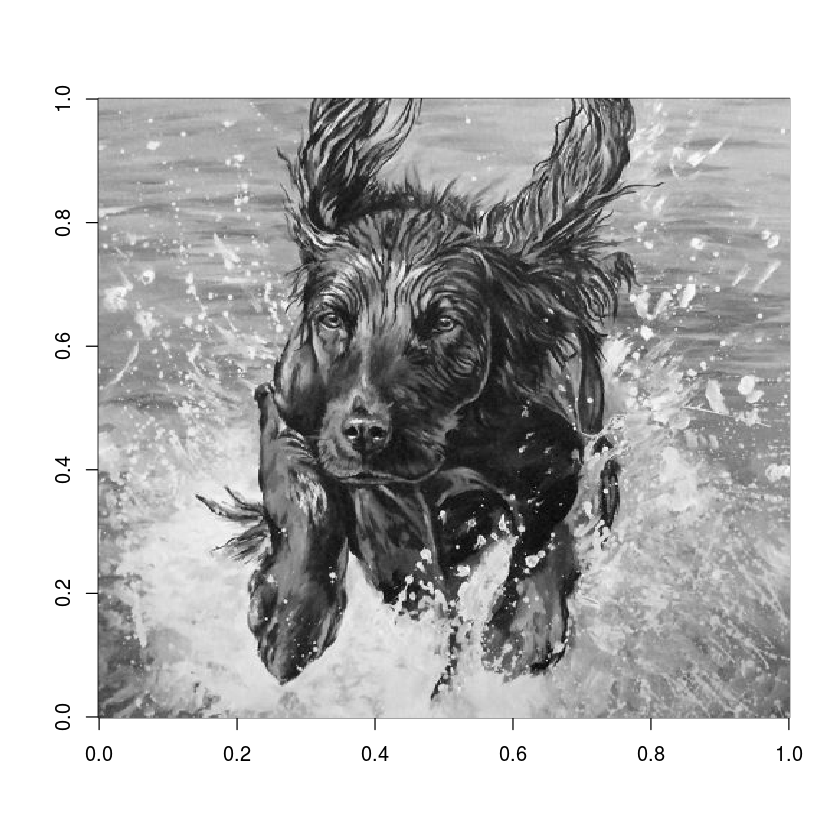

In [2]:
set.seed(3)
#Leer imagen
img<-readJPEG("dog.jpg")
imgGray<-0.3*img[,,1]+0.59*img[,,2]+0.11*img[,,3]
#Transformar la imagen
imgGray <- t(apply(imgGray, 2, rev))
# Visualizar
image(imgGray,col=gray((0:255)/255))

## Visualización de pixeles
### 1.1 Toma un renglón de la imagen y visualiza $X_t$ contra $X_{t+1}$

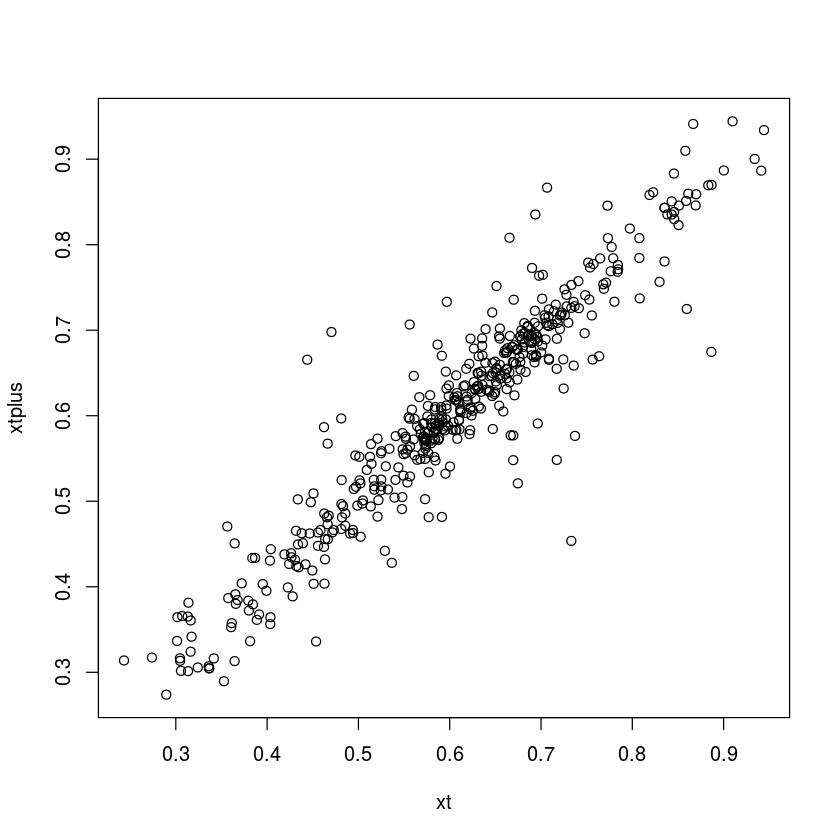

In [3]:
n<-dim(imgGray)[2]
t<-1
xt<-imgGray[t,1:n-1]
xtplus<-imgGray[t,2:n]
plot(xt, xtplus)

### 1.2. Hacer un histograma de la imagen

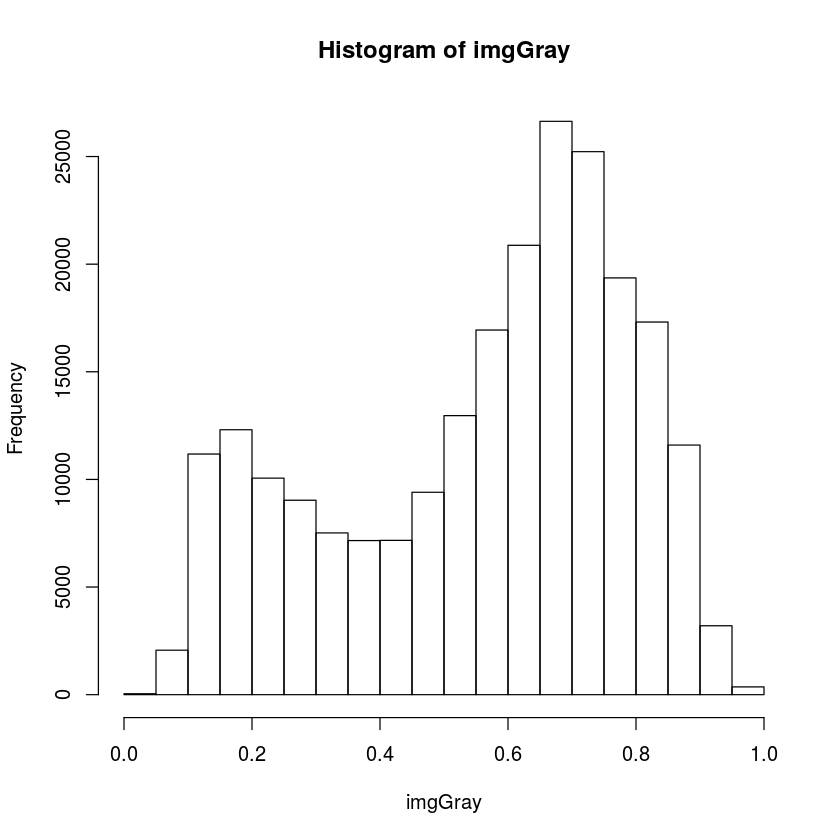

In [4]:
hist(imgGray)

## 2. Compresión usando PCA
### Consiste en dividir la imagen en bloques de cxc pixeles. Con los valores de cada bloque se forma un vector y se agrupan en una matriz de datos. La compresión consiste en proyectar los datos sobre los primeros k componentes principales. La decompresión consiste en reconstruir los datos a partir de estas proyecciones. 

In [5]:
#FUNCIONES AUXILIARES
# Divide la una imagen en bloques de cxc
mat_split <- function(M, c){
	sizeCol <-ncol(M)/c
	sizeRow <-nrow(M)/c
	splitByCol<-lapply(1:c, function(x) {M[, ((x-1)*(sizeCol)+1):(x*sizeCol)]})
	splitByColRow<-lapply(splitByCol, function(mat){ 	
		lapply(1:c, function(x) {
			mat[((x-1)*(sizeRow)+1):(x*sizeRow), ]
		})
	})	
	return(splitByColRow)
}


#Recibe una lista de matrices y devuelve una lista de vectores
unrollMatrices<-function(matList){
	lapply(1:length(matList), function(y) {
		lapply(1:length(matList[[y]]), function(x) {c(t(matList[[y]][[x]]))})	
	})
}

#Recibe una lista de vectores y devuelve una matriz
vecsToMat<-function(vecList){
	res<-matrix(unlist(vecList), byrow = TRUE, ncol=length(vecList[[1]][[1]]))
	return(res)
}

#Reconstrucción de la imagen
#Recibe una matriz de compunentes y devuelve la matriz con la imagen
matToImage<-function(matrixC){
	c<-sqrt(ncol(matrixC))
	imageList<-lapply(1:nrow(matrixC), function(x) {matrix(matrixC[x,], byrow=TRUE, ncol = c)})
	nImages<-sqrt(length(imageList))
	matImg<-lapply(0:(nImages-1), function(y) {
			do.call(rbind, imageList[seq(nImages*y+1, nImages*(y+1))])
	})
	res<-do.call(cbind, matImg)
	return(res)
}


### 2.1. Realiza la compresión de la imágen usando el procedimiento mencionado anteriormente. Puedes usar las funciones auxiliares

In [6]:
matList<-mat_split(imgGray,10)
vecList<-unrollMatrices(matList)
matGrid<-vecsToMat(vecList)	
pca_img<-prcomp(t(matGrid))
summary(pca_img)

Importance of components:
                          PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     0.6724 0.44852 0.40125 0.30822 0.30301 0.26630 0.25060
Proportion of Variance 0.2035 0.09053 0.07245 0.04275 0.04132 0.03191 0.02826
Cumulative Proportion  0.2035 0.29400 0.36645 0.40920 0.45052 0.48243 0.51069
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.23813 0.21679 0.20519 0.19983 0.19327 0.18771 0.17894
Proportion of Variance 0.02552 0.02115 0.01895 0.01797 0.01681 0.01586 0.01441
Cumulative Proportion  0.53621 0.55736 0.57630 0.59427 0.61108 0.62694 0.64135
                          PC15    PC16    PC17    PC18   PC19    PC20    PC21
Standard deviation     0.17809 0.17717 0.16985 0.16765 0.1592 0.15796 0.15488
Proportion of Variance 0.01427 0.01413 0.01298 0.01265 0.0114 0.01123 0.01079
Cumulative Proportion  0.65562 0.66974 0.68273 0.69537 0.7068 0.71800 0.72880
                          PC22    

### 2. 2 ¿Cómo influye el valor de k en la calidad de la reconstruccion?

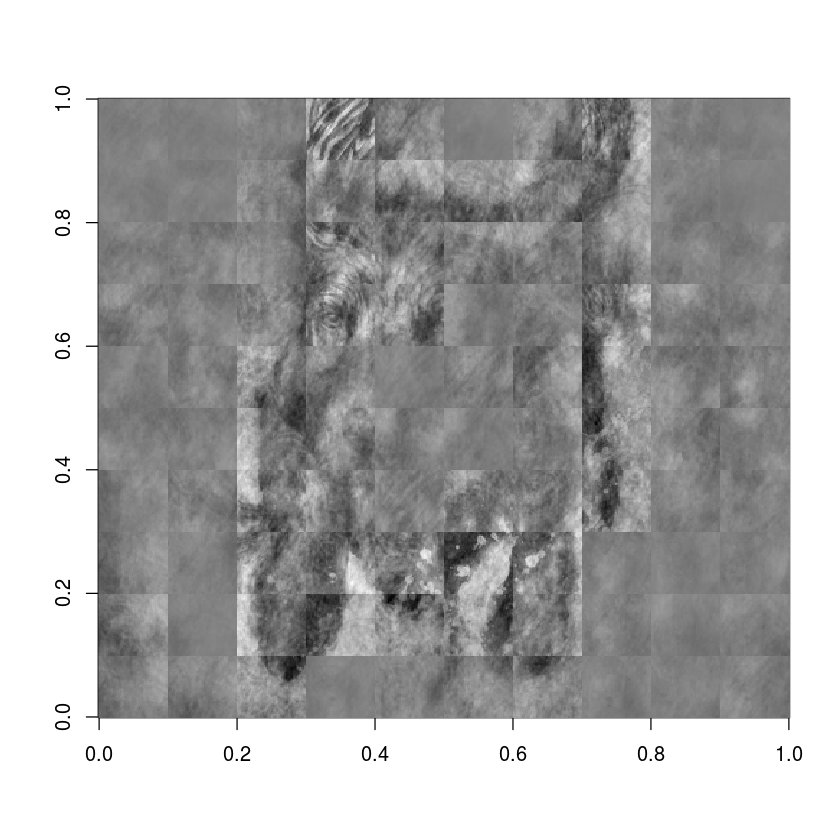

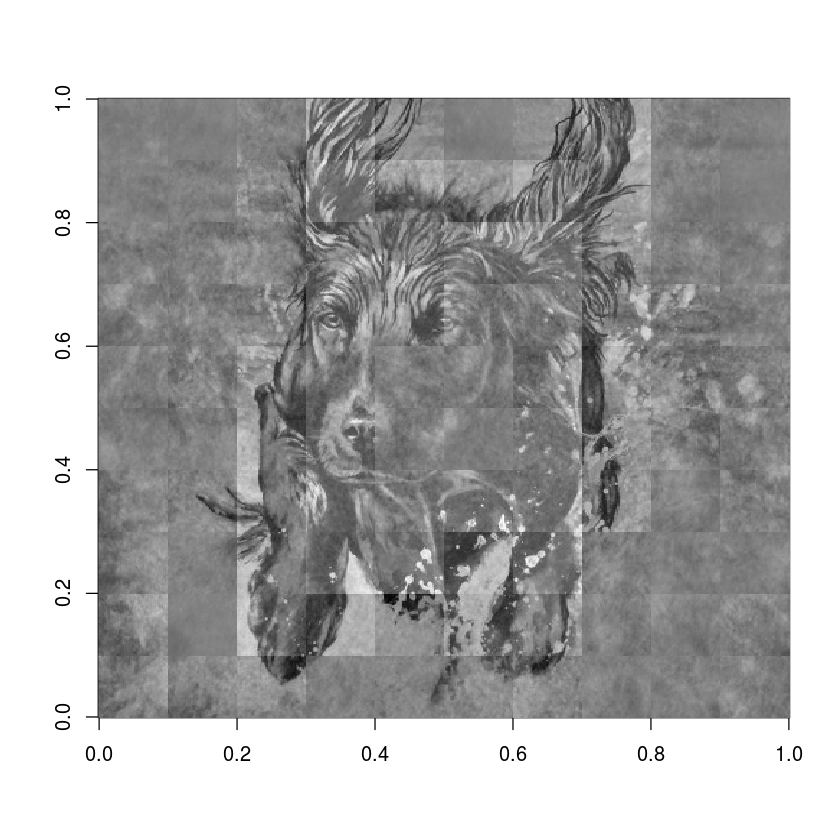

In [7]:
#Reconstruction
im<-pca_img$x[,1:14]%*%t(pca_img$rotation[,1:14])
im1<-matToImage(t(im))
image(im1, col=gray((0:255)/255))

im3<-pca_img$x[,1:46]%*%t(pca_img$rotation[,1:46])
im4<-matToImage(t(im3))
image(im4, col=gray((0:255)/255))

## 3. Segmentación usando k medias

### Una manera de segmentar una imagen en k diferentes niveles de griz consiste en utilizar el algoritmo k-medias y cambiar el nivel de gris en un pixel por el nivel de gris del centroide del cluster al cual pertenece.

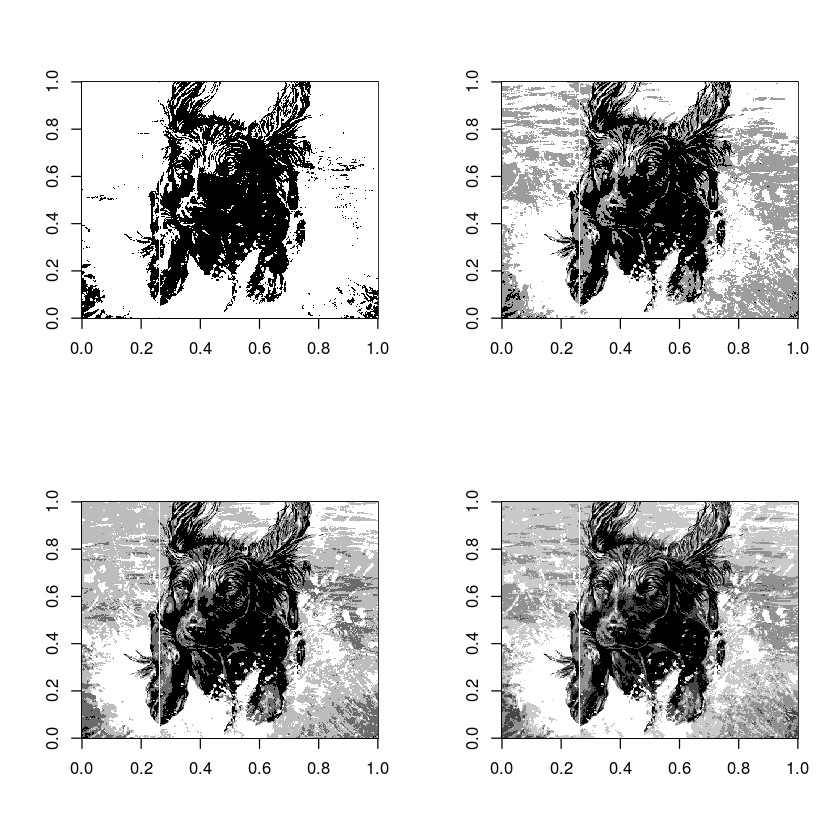

In [8]:
##Ejemplo de segmentacion usando k-medias
#Show image for k in {2,3,4,5}
par(mfrow = c(2,2))
for (k in 2:5){
	km<-kmeans(as.vector(imgGray), k)
	cluster<-km$cluster
	for (l in 1:k){
		cluster<-replace(cluster, cluster == l, km$centers[l])
	}
	centerValM<-matrix(cluster, 480, 480)
	image(centerValM,col=gray((0:255)/255))
}


### 3.1. ¿Cómo utilizarías esta técnica para imágenes a color? 

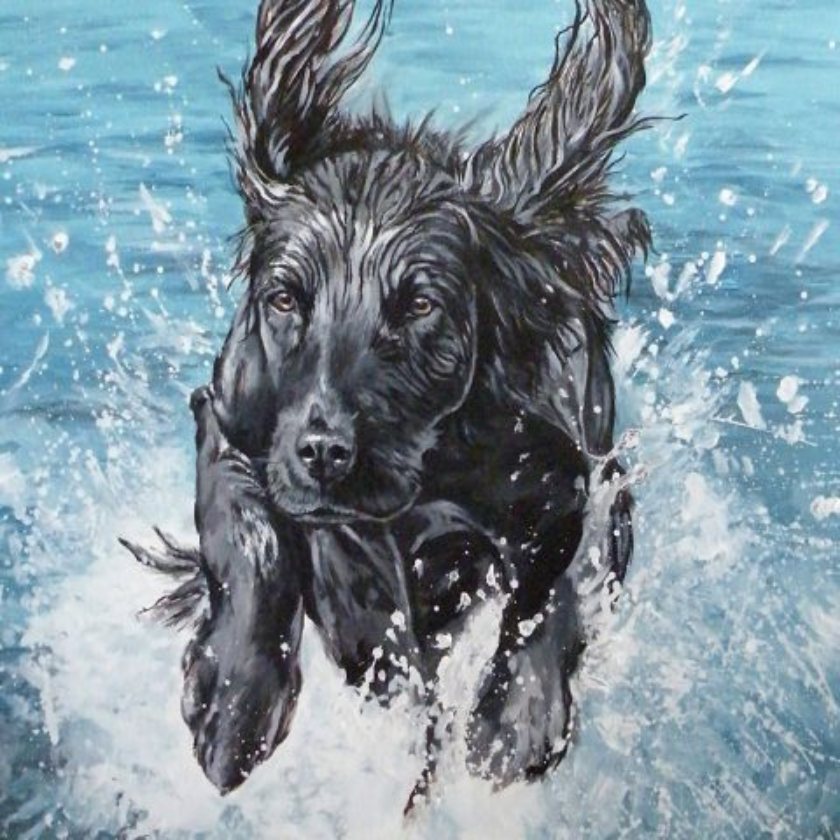

In [9]:
grid.raster(img)
data<-cbind(as.vector(img[,,1]),as.vector(img[,,2]),as.vector(img[,,3]))

In [10]:
k <- 3
km<-kmeans(data, k)
clusterR<-km$cluster
clusterG<-km$cluster
clusterB<-km$cluster

for (l in 1:k){
    clusterR<-replace(clusterR, clusterR == l, km$centers[l,1])
    clusterG<-replace(clusterG, clusterG == l, km$centers[l,2])
    clusterB<-replace(clusterB, clusterB == l, km$centers[l,3])
}

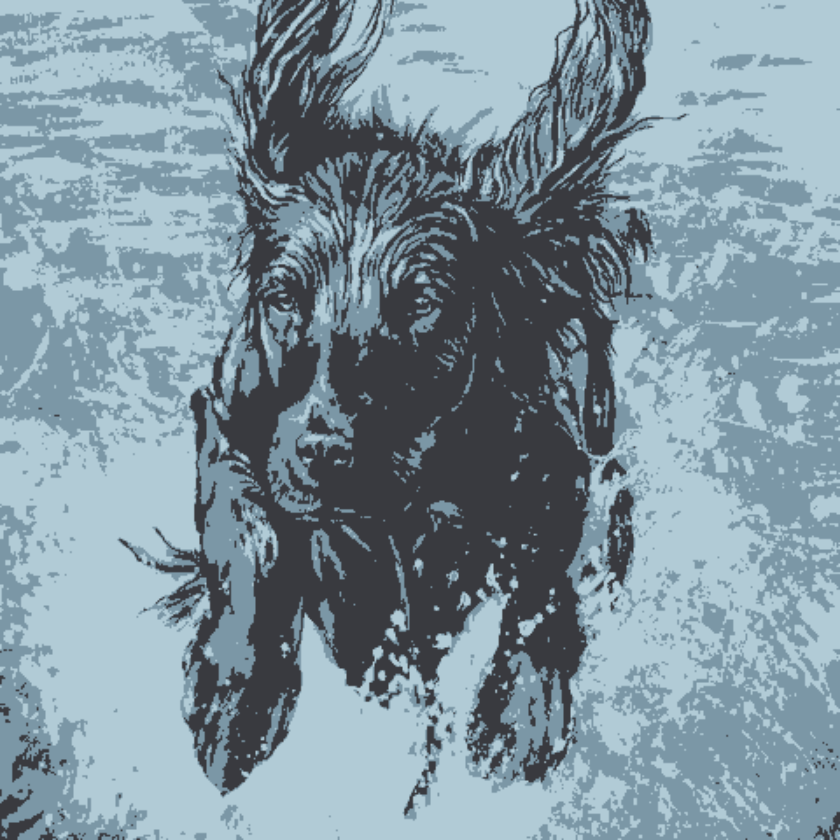

In [11]:
R<-matrix(clusterR, 480, 480)
G<-matrix(clusterG, 480, 480)
B<-matrix(clusterB, 480, 480)

segmentedImg<-array(dim=dim(img))
segmentedImg[,,1]<-R
segmentedImg[,,2]<-G
segmentedImg[,,3]<-B

grid.raster(segmentedImg)

## 4. Segmentación usando spectral clustering

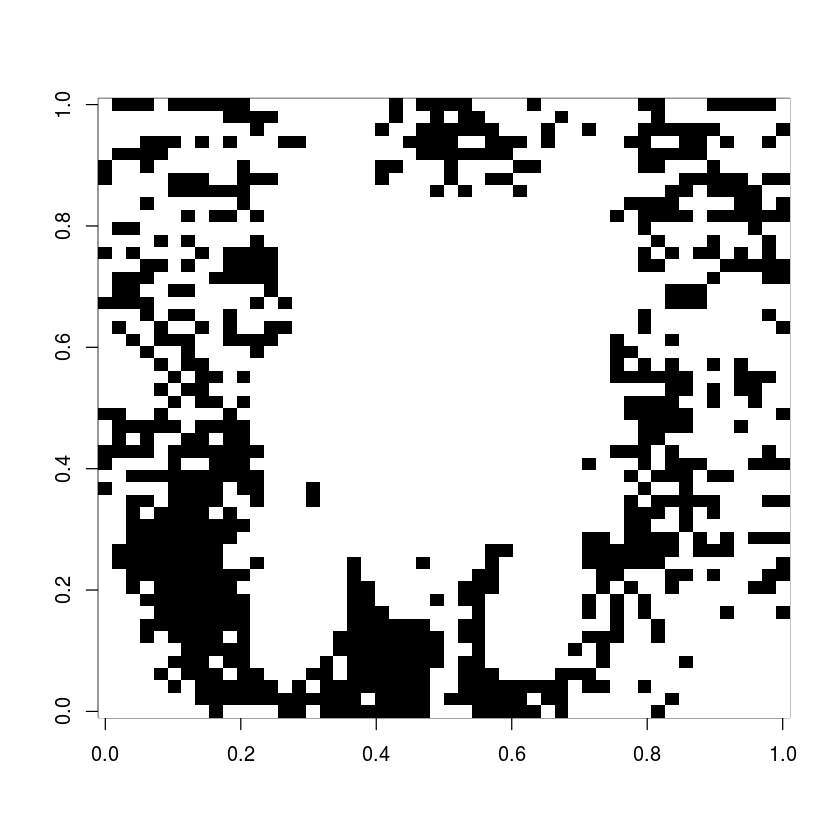

In [12]:
# Creamos un grafo donde cada nodo es un dato. 
img<-readJPEG("dogSmall.jpg")
imgGray<-0.3*img[,,1]+0.59*img[,,2]+0.11*img[,,3]
imgGray <- t(apply(imgGray, 2, rev))
data<-as.vector(imgGray)

#Definimos wij como la similitud entre el nodo i y el nodo j. 
k<-kernelMatrix(rbfdot(sigma = 1),data)
# En el grafo solo vamos a conectar los grafos con similitud alta

getAdjMat<-function(k, nneighbors){
    n<-dim(k)[1]
    adjMat <- matrix(rep(0,n^2), ncol=n)
    for(i in 1:n) {
      nearestNodes <- sort(k[i,], decreasing=TRUE)[1:nneighbors]
      for (s in nearestNodes) {
        j <- which(k[i,] == s)
        adjMat[i,j] <- k[i,j]
        adjMat[j,i] <- k[i,j] 
      }
    }
  return(adjMat)   
}

ncentroids = 2
#Matriz de adyacencia
W<-getAdjMat(k, 10)
# Matriz diagonal
D<-diag(apply(W, 1, sum))

#Laplaciano
L <-D-W
eig<-eigen(L, symmetric=TRUE)
Z   <- eig$vectors[,ncol(k)-1]
km <- kmeans(Z, centers=ncentroids)
cluster<-km$cluster - 1
centerValM<-matrix(cluster, nrow(imgGray), ncol(imgGray))
image(centerValM,col=gray((0:255)/255))